# Assignment 3
# Covid-19 Exposures in Nova Scotia
# GISY5003: Spatial Database Management
# Instructor: Jim Verran
# Author: Juan C. Reyes
# Date: December 13, 2021


# Part 1- Data Scraping, Data Cleaning, Visualization

Begin by checking your CWD depending on where you opened this file.
This document will generate a few output files containing data.

In [20]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\jreye\\OneDrive - Nova Scotia Community College\\ClassMaterial\\GISY5003SpatialDatabaseMgmt\\Labs\\Assignment3\\Submission\\ArcGISPRO_CovidMap'

# Nova Scotia Covid-19 Exposure Sites and Healthcare Facilities

# 0 -  Import libraries to work with.

#### Pandas for data frames and data cleaning.
#### GIS for mapping visualization
#### Geocode for obtaining addresses from NS. Health
#### Arcpy for creating buffer polygons and plotting on the main map.

In [6]:
#Import Libraries
import pandas as pd
from arcgis.gis import GIS
from arcgis.geocoding import geocode
import arcpy

# ArcGIS Credentials

## This is necessary for initializing the GIS object as well as for utilizing the geocode() function to allow us to obtain exposure site cooridnates.

In [17]:
password = input("Please enter your password: ")
# Create GIS Map Object. Please enter your own GIS Login Credentials.
Halifax_GIS_Map = GIS(username = "JuanCReyes1", password=password) 

Please enter your password: 


Exception: Unable to generate token.
'password' must be specified.
(Error Code: 400)

# Initialize GIS object

In [8]:
#Create a dictionary of objects to choose where to center the map orginally around.
places_dict= {"Dartmouth":"Dartmouth,Nova Scotia,Canada",
              "Halifax": "Halifax, Nova Scotia, Canada",
              "Bedford": "Bedford, Nova Scotia, Canada"
              }
#Create map object
Halifax_Covid_Exposures = Halifax_GIS_Map.map(places_dict["Dartmouth"],12)
#Insert basemap
Halifax_Covid_Exposures.basemap = "streets-night-vector" #map style
#Show map
Halifax_Covid_Exposures

MapView(layout=Layout(height='400px', width='100%'))

## (**Note that if this is the first time opening the file, you might not see anything on the map until we run the geocode process below.)

# 1.0 - Data scraping and cleaning with Pandas:

## Nova Scotia Covid-19 Exposure Data is public through: https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&order=changed&sort=desc%20


## Similarily, Nova Scotia Flights and Transit Covid-19 Exposure Data for is public through: https://www.nshealth.ca/coronavirus-exposures-transit.

In [19]:
#We we scrape 'table' contents from the exposure site website using the pandas function pd.read_html(). This handily collects all of the data visible on the page onto a pandas dataframe object.
# Public Exposures
df1 = pd.read_html("http://www.nshealth.ca/covid-exposures")
df2 = pd.read_html("https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&page=1")
df3 = pd.read_html("https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&page=2")
df4 = pd.read_html("https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&page=3")
df6 = pd.read_html("https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&page=4")
df7 = pd.read_html("https://www.nshealth.ca/coronavirus-exposures?title=&field_covid_exposure_zone_value=All&page=5")

# Flight and Transit Exposures
df_transit = pd.read_html("https://www.nshealth.ca/coronavirus-exposures-transit")
df_transit = df_transit[0].rename(columns={'Route or flight': "Place"})
#Concatenate all of our dataframes into one to compile all Covid-19 exposures onto one dataframe.
df5 = pd.concat([df1[0],df2[0],df3[0],df4[0],df6[0],df7[0],df_transit], ignore_index = True)



#################################################################
#####Check the dataframe to see which columns have NaN values####
#################################################################
if df5.isnull().values.any():
    print("Check for NaN values in our columns")
    print("Place: " + str(df5["Place"].isnull().values.any()))
    print("Potential Exposure Window: " + str(df5["Potential Exposure Window"].isnull().values.any()))
    print("Address: " + str(df5["Address"].isnull().values.any()))
    #print("Details: " + str(df5["Details"].isnull().values.any()))
    print("Zone: " + str(df5["Zone"].isnull().values.any()))
    print("Last Updated: " + str(df5["Last Updated"].isnull().values.any()))
    print("Exposure Area: " + str(df5["Exposure area"].isnull().values.any()))
#print("no null values")

#Exposure Area NAN

if df5["Exposure area"].isnull().values.any():
    print("Empty values in exposure area")
    null_exposures_index = df5[df5["Exposure area"].isnull().values].index
    df5["Exposure area"].iloc[null_exposures_index] = df5["Place"].iloc[null_exposures_index]

##Zone Column NAN
if df5['Zone'].isnull().values.any():
    print("Zone value empty due to flights")
    null_zone_index = df5[df5['Zone'].isnull().values].index
    df5.iloc[null_zone_index,4] = "Flight"
    print("Zone Data Cleaning Complete: "+ str(df5["Zone"].isnull().any()))
#print("no null zone values")

####Data Cleaning####
#Identify individual flight and transit routes into their own respective dataframes.


#Identify Covid Flights and Transit Routes
print("Attributing Covid Flights to Halifax Stanfield International Airport")
covid_flights = df5[df5["Place"].str.contains("to Halifax")]
covid_bus_routes = df5[(df5["Place"].str.contains("Transit")) | (df5["Place"].str.contains("Route"))]

#Update Covid Flights' Address vakue to Halifax Stanfield International Airport:
df5["Address"].iloc[covid_flights.index] = "Halifax Stanfield International Airport"
df5["Zone"].iloc[covid_flights.index] = "Flight"

#Similarily, update Covid Routes Address to the Transit Route
df5["Address"].iloc[covid_bus_routes.index] = "Halifax Transit Bridge Terminal"
#df5["Zone"].iloc[covid_bus_routes.index] = "Halifax Transit Bridge Terminal"


#####################################################
################Creating Geolocations################
#####################################################

#Create a Geolocation Address which will be fed into ArcGIS
print("Creating A Geolocation Address Column For Each Exposure Site...")

#We create a Geolocation Address column which will be fed into the geocoding function. We join both dataframe columns by use of a lambda function. 
df5['Geolocation Address'] = df5[['Place', 'Address']].apply(lambda x: ' - '.join(x.map(str)), axis=1)
#We take the Address calculated and append Nova Scotia to the location. This helps the geocode function to identify our location more accurately.
df5['Geolocation Address'] = df5['Geolocation Address'] + ", Nova Scotia, Canada" 
print("Geolocation Address Column: Included")

#####################################################
################Apply Geocode Function###############
#####################################################
print("Creating Geolocation Address Coordinates")
##Create GIS Object!
print("Creating ArcGIS Map Object")

#Call the map and wipe any previous points currently plotted.
Halifax_GIS_Map = GIS()



##Create a new column which will store our geocoded results.
df5['Geolocation Address Coords'] = df5['Geolocation Address'].apply(lambda x: geocode(x,out_fields="address,location,City,Country,URL"))
print("Geocoding Complete")

#########################################################################################
####################Obtaining Latitude and Longitude for each address####################
#########################################################################################
print("Create Latitude & Longitude Columns")
indices = df5['Geolocation Address Coords'].index
#We create an empty list array to store a series of longitude and latitude values
longitudeseries = []
latitudeseries = []
print("Creating Latitude and Longitude Columns")
for number in indices:
    #print(number)
    longitudeseries.append(df5['Geolocation Address Coords'][number][0]["location"]["x"])
    latitudeseries.append(df5['Geolocation Address Coords'][number][0]["location"]["y"])
#Create new columns to our dataframe containing the spatial information for each exposure site.
df5["longitude"] = longitudeseries
df5["latitude"] = latitudeseries

#########################################################################################
####################Export to CSV########################################################
#########################################################################################

print("Exporting to CSV")
df5.to_csv('./covidlocations.csv')
print("CSV Complete")

Check for NaN values in our columns
Place: False
Potential Exposure Window: False
Address: True
Zone: True
Last Updated: False
Exposure Area: True
Empty values in exposure area
Zone value empty due to flights
Zone Data Cleaning Complete: False
Attributing Covid Flights to Halifax Stanfield International Airport
Creating A Geolocation Address Column For Each Exposure Site...
Geolocation Address Column: Included
Creating Geolocation Address Coordinates
Creating ArcGIS Map Object
Geocoding Complete
Create Latitude & Longitude Columns
Creating Latitude and Longitude Columns
Exporting to CSV
CSV Complete


# Covid-19 Exposure Data for Nova Scotia

In [20]:
df5

,Place,Potential Exposure Window,Address,Covid Exposure Or Precaution,Zone,Last Updated,Exposure area,Geolocation Address,Geolocation Address Coords,longitude,latitude
0,Kiju Restaurant,"Tue, 12/14/2021 - 18:30 to 21:30","50 Maillard Street, Membertou",Precaution,Eastern,12/17/2021 - 20:56,Kiju Restaurant,"Kiju Restaurant - 50 Maillard Street, Memberto...","[{'address': '50 Maillard St, Sydney, Cape Bre...",-60.191981,46.120673
1,Alteregos Cafe and Catering,"Tue, 12/14/2021 - 15:15 to 17:00","2193 Gottingen St., Halifax",Precaution,Central,12/16/2021 - 20:13,Alteregos Cafe and Catering,Alteregos Cafe and Catering - 2193 Gottingen S...,"[{'address': 'Alterego's Cafe & Catering', 'lo...",-63.584910,44.653100
2,Alteregos Cafe and Catering,"Mon, 12/13/2021 - 15:15 to 17:00","2193 Gottingen St., Halifax",Precaution,Central,12/16/2021 - 20:11,Alteregos Cafe and Catering,Alteregos Cafe and Catering - 2193 Gottingen S...,"[{'address': 'Alterego's Cafe & Catering', 'lo...",-63.584910,44.653100
3,Sackville High School gymnasium and lobby,"Mon, 12/13/2021 - 14:30 to 21:00","1 Kingfisher Way, Lower Sackville",Precaution,Central,12/16/2021 - 20:09,Sackville High School gymnasium and lobby,Sackville High School gymnasium and lobby - 1 ...,"[{'address': 'Sackville High School', 'locatio...",-63.673750,44.775330
4,Midtown – Boomers Tavern & Lounge,"Sun, 12/12/2021 - 21:30 to Mon, 12/13/2021 - 0...","1744 Grafton Street, Halifax",Precaution,Central,12/17/2021 - 21:20,Midtown – Boomers Tavern & Lounge,Midtown – Boomers Tavern & Lounge - 1744 Graft...,"[{'address': '1744 Grafton St, Halifax, Nova S...",-63.575882,44.647724
...,...,...,...,...,...,...,...,...,...,...,...
296,Air Canada 614 Toronto to Halifax,"Fri, 12/03/2021 - 14:00 to 17:00",Halifax Stanfield International Airport,Exposure,Flight,12/15/2021 - 14:32,"Passengers in rows 11-17, seats, C, D, E and F.",Air Canada 614 Toronto to Halifax - Halifax St...,[{'address': 'Halifax Stanfield International ...,-63.515310,44.886260
297,Halifax Transit Route #041 (Dartmouth-Dalhousie),"Fri, 12/03/2021 - 13:00 to 13:15",Halifax Transit Bridge Terminal,Precaution,Central,12/15/2021 - 14:43,Scotia Square to LeMarchant St,Halifax Transit Route #041 (Dartmouth-Dalhousi...,"[{'address': '41 Dartmouth Rd, Bedford, Halifa...",-63.652517,44.728288
298,Halifax Transit Route #024 (Leiblin Park),"Fri, 12/03/2021 - 13:00 to 13:30",Halifax Transit Bridge Terminal,Precaution,Central,12/15/2021 - 14:43,South Park and South St to Leiblin and Juniper,Halifax Transit Route #024 (Leiblin Park) - Ha...,"[{'address': '24 Leiblin Dr, Halifax, Nova Sco...",-63.625627,44.604543
299,Halifax Transit Route #009A (Greystone),"Fri, 12/03/2021 - 08:45 to 09:00",Halifax Transit Bridge Terminal,Precaution,Central,12/15/2021 - 14:44,Mumford Road Terminal to Scotia Square,Halifax Transit Route #009A (Greystone) - Hali...,"[{'address': '009A Greystone Dr, Halifax, Nova...",-63.611427,44.602949


## Define Map Icon

In [21]:
geotag_symbol_dict_redbullseye = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/Basic/esriCrimeMarker_86.png","contentType":"image/png","width":16,"height":16}
geotag_symbol_dict_redfirefly = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"https://static.arcgis.com/images/Symbols/Firefly/FireflyD20.png","contentType":"image/png","width":24,"height":24}
geotag_symbol_dict_radioactive = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Radioactive.png","contentType":"image/png","width":16,"height":16}


# Iterate through Geocoded results and apply .draw() function to display them on our map.
## We also call a content.search() obtaining Healthcare facitilies in Canada data.

This will help us study spatial relationships between Covid-19 Exposures with respect to the spatial location of healthcare facilities such as hospitals, nursing homes, and care homes.


In [22]:
# Iterate through each geocoded result.
for number in range(0,len(df5['Geolocation Address Coords'])):
    
    #Define parameters for the .draw() function.
    # Exposure Location
    location = df5['Geolocation Address Coords'][number][0]["location"]
    # Pop Up Definition and Symbol 
    popup = {"title": pd.Series(df5["Geolocation Address"])[number], "content": pd.Series(df5["Exposure area"])[number]}
    symbol = geotag_symbol_dict_radioactive
    attributes = {"test": "what"}
    
    #Plot on the map!
    print("Plotting location number " + str(number) + "/ " +str(len(df5["Geolocation Address Coords"])-1)+": " + pd.Series(df5["Geolocation Address"])[number] )
    Halifax_Covid_Exposures.draw(shape = location,symbol=symbol,popup=popup,attributes = "test")
    



Plotting location number 0/ 300: Kiju Restaurant - 50 Maillard Street, Membertou, Nova Scotia, Canada
Plotting location number 1/ 300: Alteregos Cafe and Catering - 2193 Gottingen St., Halifax, Nova Scotia, Canada
Plotting location number 2/ 300: Alteregos Cafe and Catering - 2193 Gottingen St., Halifax, Nova Scotia, Canada
Plotting location number 3/ 300: Sackville High School gymnasium and lobby - 1 Kingfisher Way, Lower Sackville, Nova Scotia, Canada
Plotting location number 4/ 300: Midtown – Boomers Tavern & Lounge - 1744 Grafton Street, Halifax, Nova Scotia, Canada
Plotting location number 5/ 300: Zatsman Sportsplex Gymnasium - Basketball game, 110 Wyse Rd., Dartmouth, Nova Scotia, Canada
Plotting location number 6/ 300: The Resolutes Club - 5461 Inglis Street, Halifax, Nova Scotia, Canada
Plotting location number 7/ 300: The Old Triangle - 5136 Prince Street, Halifax, Nova Scotia, Canada
Plotting location number 8/ 300: Kai Brady’s - 5679 Spring Garden Road, Halifax, Nova Scotia,

Plotting location number 146/ 300: Coldstream Clear Distillery - 25 James St., Antigonish, Nova Scotia, Canada
Plotting location number 147/ 300: Kent Building Supplies - 35 Market St., Antigonish, Nova Scotia, Canada
Plotting location number 148/ 300: Justamere Café & Bakery - 137 Church St., Antigonish, Nova Scotia, Canada
Plotting location number 149/ 300: St. Francis Xavier University - Morrison Dining Hall, Nova Scotia, Canada
Plotting location number 150/ 300: Dalhousie University - Killam Memorial Library - Killam Memorial Library, Nova Scotia, Canada
Plotting location number 151/ 300: Main Street Cafe - Maritime Inn Antigonish - 158 Main St., Antigonish, Nova Scotia, Canada
Plotting location number 152/ 300: Immaculate Conception Church - 2881 Louisburg Main-a-Dieu, Main-a-Dieu, Nova Scotia, Canada
Plotting location number 153/ 300: Esquire Restaurant - 772 Bedford Highway, Halifax, Nova Scotia, Canada
Plotting location number 154/ 300: Esquire Restaurant - 772 Bedford Hwy., Ha

Plotting location number 289/ 300: Halifax Transit Route #182 (First Lake Express) - Halifax Transit Bridge Terminal, Nova Scotia, Canada
Plotting location number 290/ 300: Air Canada 8106 Montreal to Halifax - Halifax Stanfield International Airport, Nova Scotia, Canada
Plotting location number 291/ 300: Maritime Bus - nan, Nova Scotia, Canada
Plotting location number 292/ 300: Maritime Bus - nan, Nova Scotia, Canada
Plotting location number 293/ 300: WestJet 2901 Cancun to Halifax - Halifax Stanfield International Airport, Nova Scotia, Canada
Plotting location number 294/ 300: Air Canada 1259 Orlando to Halifax - Halifax Stanfield International Airport, Nova Scotia, Canada
Plotting location number 295/ 300: Air Canada 602 Toronto to Halifax - Halifax Stanfield International Airport, Nova Scotia, Canada
Plotting location number 296/ 300: Air Canada 614 Toronto to Halifax - Halifax Stanfield International Airport, Nova Scotia, Canada
Plotting location number 297/ 300: Halifax Transit R

# Healthcare Facilities in Canada: https://www.statcan.gc.ca/en/lode/databases/odhf

We are also interested in studying the spatial extent of healthcare in Nova Scotia, and the spatial proximity of Covid-19 Exposures with respect to hospitals,care homes, and nursing homes.

In [23]:
covid_canada = Halifax_GIS_Map.content.search("title: Open Database of Healthcare Facilities - Canada")
covid_canada[0]
covid_layer = Halifax_GIS_Map.content.get(covid_canada[0].id)
Halifax_Covid_Exposures.add_layer(covid_layer,options={'opacity':1.2})

# Exporting to ArcGIS Pro with ArcPy

We make use of the functionality of ArcPy XYTableToPoint(): https://pro.arcgis.com/en/pro-app/2.8/tool-reference/data-management/xy-table-to-point.htm
This will create a Point Layer with our generated file.

In [24]:
arcpy.management.XYTableToPoint(r"covidlocations.csv","HRMCovidLocations","longitude","latitude")

<Result 'C:\\Users\\jreye\\OneDrive - Nova Scotia Community College\\ClassMaterial\\GISY5003SpatialDatabaseMgmt\\Labs\\Assignment3\\Submission\\ArcGISPRO_CovidMap\\Default.gdb\\HRMCovidLocations'>

# Finally we create a buffer polygon from using the ArcPy Buffer() function: https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/buffer.htm

In [25]:
arcpy.analysis.Buffer(r"HRMCovidLocations", r"CovidBuffer0_5km", "0.1 Kilometers")

<Result 'C:\\Users\\jreye\\OneDrive - Nova Scotia Community College\\ClassMaterial\\GISY5003SpatialDatabaseMgmt\\Labs\\Assignment3\\Submission\\ArcGISPRO_CovidMap\\Default.gdb\\CovidBuffer0_5km'>

#### More Information on the ODHF Dataset:

In [12]:
covid_canada = Halifax_GIS_Map.content.search("title: Open Database of Healthcare Facilities - Canada")
covid_canada[0]

<Item title:"Open Database of Healthcare Facilities" type:Feature Layer Collection owner:pheersink_exchange>

In [19]:
from arcgis.gis import GIS
gis = GIS("http://arcgis.com", "username", "password")
search_results = gis.content.search("title:Puget Sound Traffic Incidents", item_type="Feature Service")
feature_layer_collection = search_results[0]
feature_layer = feature_layer_collection.layers[0]
for i in feature_layer.properties.fields:
    print(i['name'])

Exception: Unable to generate token.
Invalid username or password.
(Error Code: 400)

In [18]:
from arcgis.gis import GIS
password = input("enter your password: ")
gis = GIS("http://arcgis.com",username = "JuanCReyes1", password=password) 

enter your password: 


Exception: Unable to generate token.
'password' must be specified.
(Error Code: 400)

In [14]:
search_results = gis.content.search("title:Puget Sound Traffic Incidents", item_type="Feature Service")
feature_layer_collection = search_results[0]

<Item title:"Puget Sound Traffic Incidents" type:Feature Layer Collection owner:EsriTrainingSvc>
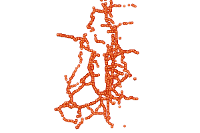

In [15]:
feature_layer_collection

In [16]:
feature_layer = feature_layer_collection.layers[0]
for i in feature_layer.properties.fields:
    print(i['name'])

OBJECTID
id
state
stop_date
stop_time
location_r
county_nam
county_fip
fine_grain
police_dep
driver_age
driver_a_1
violation_
violation
search_con
search_typ
search_t_1
contraband
stop_outco
is_arreste
violations
officer_id
highway_ty
road_numbe
milepost
lat
lon
contact_ty
enforcemen
drugs_rela
